## Welcome to  
# CONWAY'S GAME OF LIFE
----


### The 3 rules of the game are:

### 1. Any live cell with two or three live neighbours survives.
### 2. Any dead cell with three live neighbours becomes a live cell.
### 3. All other live cells die in the next generation. Similarly, all other dead cells stay dead.


---
 

## Library Imports
### run this before running anything else


---

## what is new in Jewel2?
### in Jewel the neural networks were built using tensorflow. In Jewel2 this will all run on pytorch.

In [ ]:
### CONWAY'S GAME OF LIFE 
### Welcome to Conway's Game of Life 
### the 3 rules of the game are:
#1. Any live cell with two or three live neighbours survives.
#2. Any dead cell with three live neighbours becomes a live cell.
#3. All other live cells die in the next generation. Similarly, all other dead cells stay dead.

import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
import pylab as pl
import random
import pandas as pd
import torch
import torchvision
from tqdm.notebook import tqdm
device = torch.device("cuda")


Population: 319.0


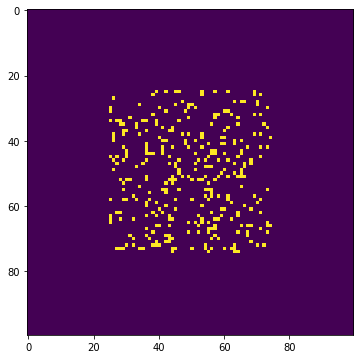

In [ ]:
world = np.zeros((100,100))
### Random positions ###
lower_center =25
upper_center =75
population = np.random.randint(low=100, high=600, size=1)
latitude = np.random.randint(low=lower_center, high=upper_center, size=population)
longitude = np.random.randint(low=lower_center, high=upper_center, size=population)
source = np.ones(population, dtype=int)
world[(longitude),(latitude)] = source


def watch_world(matrix=world):
    print(f"Population: {matrix.sum()}")
    plt.figure(1, figsize=(6,6))
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.grid(False)
    
    
watch_world()

world.shape[0]#1->cols, 0->rows
initial_world = world.copy()


## Frame Shape
### The frame_shape tuple defines the size of the world-matrix in terms of rows and columns. refer to frame_shape when defining your matrix dimensions in order to maintain consistency.

In [ ]:
frame_shape = (10,10)

## Evolution function
### Run this if you need to make a new model

In [ ]:

def evolve(frame):
    neighbours = sum(np.roll(np.roll(frame, row, 0), col, 1)
                 for row in (-1, 0, 1) for col in (-1, 0, 1)
                 if (row != 0 or col != 0))
    return (neighbours == 3) | (frame & (neighbours == 2)).astype(int)


## Data generation functions
### Run this cell if you need to make a new model

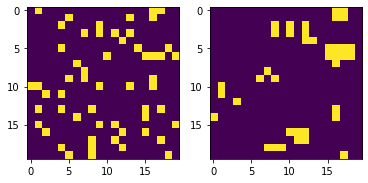

In [ ]:

class Data():
  def __init__(self, frame_shape, steps, num_frames):
    super(Data, self).__init__()
    self.frame_shape = frame_shape
    self.rows=self.frame_shape[0]
    self.cols=self.frame_shape[1]
    self.steps = steps
    self.num_frames = num_frames

  def spawn(self):
    #population = np.random.randint(low=10, high=60, size=1)
    frame = np.zeros([self.rows,self.cols])#[rows, cols]
    population = int((self.rows*self.cols)*0.15)
    lower_center = 0
    upper_center = int((frame.shape[1]))
    latitude = np.random.randint(low=lower_center, high=upper_center, size=population)
    longitude = np.random.randint(low=lower_center, high=upper_center, size=population)
    source = np.ones(population, dtype=int)
    frame[(longitude),(latitude)] = source
    return frame.astype(int)

  def torus(self, X):
    return self.reshape_input(np.array([
        np.pad(x.reshape(self.frame_shape), (self.steps,self.steps), mode = 'wrap')
        for x in X
    ]))

  def step(self, frame):
    frame = frame.astype(int)
    for i in range(self.steps):
        frame = evolve(frame)
    return frame.astype(int)

  def collection(self):
    return np.array([
        self.spawn()
        for _ in tqdm(range(self.num_frames))
    ]).astype(int)

  def snapshots(self,frame):
    #frame = cp_to_np(frame)
    if len(frame.shape) == 2:
      f = frame
    else:
      index = np.random.randint(0,frame.shape[0],1)
      f = frame[index]
    fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(6,6))
    ax1.imshow(f, cmap='viridis', interpolation='nearest')
    #plt.show()
    ax2.imshow(self.step(f), cmap='viridis', interpolation='nearest')

  def reshape_input(self, f):
    return f.reshape(f.shape[0], 1, f.shape[1], f.shape[2])
                      
  def generator(self):
    X = self.collection()
    X_copy = np.copy(X)
    y = np.array([
        self.step(X_copy[f]) for f in tqdm(range(self.num_frames))
    ])
    
    X = self.reshape_input(X)
    y = self.reshape_input(y)
    print("Dataset generation successful!")
    return self.torus(X), y

test_data = Data(frame_shape=(20,20), steps=1, num_frames=30)
test_data.snapshots(test_data.spawn())



In [ ]:
small_data = Data(frame_shape=(20,20), steps=1, num_frames=30000)
big_data = Data(frame_shape=(20,20), steps=1, num_frames=300000)
X, Y = big_data.generator()


  0%|          | 0/300000 [00:00<?, ?it/s]

  0%|          | 0/300000 [00:00<?, ?it/s]

Dataset generation successful!


AttributeError: ignored

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, Y, purpose):
    super(Dataset, self).__init__()
    self.X = X
    self.Y = Y
    
    self.purpose = purpose

    if self.purpose == "train":
      self.x, self.y = self.X[:int((self.X).shape[0]*0.7)], self.Y[:int((self.Y).shape[0]*0.7)]
    elif self.purpose == "val":
      self.x, self.y = self.X[int((self.X).shape[0]*0.7):int((self.X).shape[0]*0.85)], self.Y[int((self.Y).shape[0]*0.7):int((self.Y).shape[0]*0.85)]
    elif self.purpose == "test":
      self.x, self.y = self.X[int((self.X).shape[0]*0.85):], self.Y[int((self.Y).shape[0]*0.85):]
    elif self.purpose == "all":
      self.x, self.y = self.X, self.Y
    else:
      print("specify 'train', 'val', 'test' or 'all'")
    

  def __getitem__(self, index):
    return torch.tensor(self.x)[index], torch.tensor(self.y)[index]

  def __len__(self):
    return len(self.x)

In [ ]:
train_set1 = Dataset(X=X, Y=Y, purpose="train")
train_loader1 = torch.utils.data.DataLoader(dataset=train_set1, batch_size=32, shuffle=True)


In [ ]:
val_set1 = Dataset(X=X, Y=Y, purpose="val")
val_loader1 = torch.utils.data.DataLoader(dataset=val_set1, batch_size=32, shuffle=True)


In [ ]:
test_set1 = Dataset(X=X, Y=Y, purpose="test")
test_loader1 = torch.utils.data.DataLoader(dataset=test_set1, batch_size=32, shuffle=True)


In [ ]:
train_set1[0][0].shape

torch.Size([1, 20, 20])

In [ ]:

for x,t in train_loader1:
  print(x.shape)


torch.Size([32, 1, 20, 20])
torch.Size([32, 1, 20, 20])
torch.Size([32, 1, 20, 20])
torch.Size([32, 1, 20, 20])
torch.Size([32, 1, 20, 20])
torch.Size([32, 1, 20, 20])


KeyboardInterrupt: ignored

In [ ]:
'''
#Training data
X_train, y_train = data_generator(100, 1, 20, 20)
print(X_train.shape)
print(y_train.shape)
'''

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

(100, 20, 20, 1)
(100, 20, 20, 1)


(20, 20, 20, 1)

In [ ]:
'''
#Validation data
X_val, y_val = data_generator(10000, 1, 20, 20)
print(X_val.shape)
print(y_val.shape)
'''

SyntaxError: ignored

In [ ]:
'''
#Test data
X_test, y_test = data_generator(20000, 1, 20, 20)
print(X_test.shape)
print(y_test.shape)
'''

(20000, 20, 20, 1)
(20000, 20, 20, 1)


## Jewel2 - model N1 - 1 evolution step

#### The cell below is only for compiling the model. To fit and train the model there is a function designed for that purpose.

In [ ]:
class SimpleNetwork(torch.nn.Module):
  def __init__(self,Q, D, steps):
    super(SimpleNetwork, self).__init__()
    
    self.conv = torch.nn.Conv2d(in_channels=1, out_channels=Q, kernel_size=(1+2*steps,1+2*steps), stride=1, padding=1)
    self.relu = torch.nn.ReLU()
    self.flatten = torch.nn.Flatten()
    self.fc1 = torch.nn.Linear((128*Q*20*20), (128*D*20*20), bias=True)
    self.fc2 = torch.nn.Linear(in_features=(128*D*20*20),out_features=(128*1*20*20), bias=True)
    self.sigmoid = torch.nn.Sigmoid()

  def forward(self, x):
    B = x.shape[0]
    x = self.conv(x)
    x = self.relu(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    x = torch.reshape(x, (B, 1, 20, 20))
    y = self.sigmoid(x)
    return y


In [ ]:
class PSigmoid(torch.nn.Module):
    def __init__(self):
        super(PSigmoid, self).__init__()
        self.p = torch.nn.Parameter(torch.ones((1,28,28)))
    
    def forward(self, x):
        return self.p/(1+torch.exp(-x))



In [ ]:
class GateSigmoid(torch.nn.Module):
    def __init__(self):
        super(GateSigmoid, self).__init__()
        self.p = torch.nn.Parameter(torch.ones((1)))
    
    def forward(self, x):
        return 1/(1+torch.exp(-x*self.p))

In [ ]:
class ConvNetwork(torch.nn.Module):
  def __init__(self,Q, steps):
    super(ConvNetwork, self).__init__()
    
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=Q, kernel_size=(1+2*steps,1+2*steps), stride=1, padding=0, padding_mode="circular")
    self.conv2 = torch.nn.Conv2d(in_channels=Q, out_channels=1, kernel_size=(1+2*steps,1+2*steps), stride=1, padding=steps, padding_mode="circular")
    self.relu = torch.nn.ReLU()
    self.dropout = torch.nn.Dropout2d(p=0.2)
    self.prelu = torch.nn.PReLU()
    self.flatten = torch.nn.Flatten()
    self.sigmoid = torch.nn.Sigmoid()

  def forward(self, x):
    x = self.conv1(x)
    x = self.dropout(x)
    x = self.relu(x)
    x = self.conv2(x)
    y = self.sigmoid(x)
    return y

In [ ]:
### Using DataLoader - Doesn't work ###
'''
from tqdm.notebook import tqdm
device = torch.device("cuda")
network1 = SimpleNetwork(Q=50, D=100, steps=1)
network1 = network1.to(device)
loss = torch.nn.BCELoss()
optimizer = torch.optim.SGD(params=network1.parameters(), lr=0.001)
learning_plot = []
epochs = 10
val_load_len = len(val_loader1)

for epoch in tqdm(range(epochs)):
  for x, t in tqdm(train_loader1):
    optimizer.zero_grad()
    y = network1(x.to(device))
    J = loss(y.to(device), t.to(device))
    learning_plot.append(J.item())
    J.backwards()
    optimizer.step()

  with torch.no_grad():
    j_val = 0
    for x, t in val_loader1:
      y = network(x.to(device))
      j = loss(y.to(device), t.to(device))
      learning_plot.append(j.item())
      j_val += j
  print(f"epoch {epoch}, Loss = {j/val_load_len}")
'''

In [ ]:
def accuracy(y, x, t,steps=1):
  pred_acc = 1-(torch.sum(torch.abs(y-t))/torch.numel(y))
  data_acc = 1-(torch.sum(torch.abs(x-torch.nn.functional.pad(t,(steps,steps,steps,steps))))/torch.numel(t))
  return data_acc, pred_acc


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def train_simple(network, x, y, epochs, suffix, steps,lr=0.01, dev="cuda", rounding=False):
  X = torch.tensor(x)
  Y = torch.tensor(y)
  device = torch.device(dev)
  network1 = network.to(device)
  loss = torch.nn.BCELoss()
  optimizer = torch.optim.SGD(params=network1.parameters(), lr=lr)
  learning_plot = []
  accuracy_plot = []


  train_index = int(len(X)*(25/30))
  val_index = int(len(X)*(275/300))
  val_load_len = val_index-train_index
  B_size = 50


  for epoch in tqdm(range(epochs)):
    for i in tqdm(range(train_index//B_size)):
      x = X[i:i+B_size].float()
      t = Y[i:i+B_size].float()
      optimizer.zero_grad()
      y = network1(x.to(device))
      if rounding == True:
        y = torch.round(y)
      J = loss(y.to(device), t.to(device))
      learning_plot.append(J.item())
      J.backward()
      optimizer.step()

    with torch.no_grad():
      j_val = 0
      d_acc = 0
      p_acc = 0
      for i in tqdm(range((train_index//B_size),(val_index//B_size))):
        x = X[i:i+B_size].float()
        t = Y[i:i+B_size].float()
        y = network1(x.to(device))
        data_acc, pred_acc = accuracy(y.to(device),x.to(device),t.to(device), steps) 
        accuracy_plot.append(pred_acc.item())
        j = loss(y.to(device), t.to(device))
        learning_plot.append(j.item())
        d_acc += data_acc.item()
        p_acc += pred_acc.item()
        j_val += j.item()
    print(f"epoch {epoch}, Loss = {j_val/(val_load_len/B_size)}")
    print(f"inherrent accuracy = {d_acc*100/(val_load_len/B_size):1.4f} %, prediction accuracy = {p_acc*100/(val_load_len/B_size):1.4f} %")
    torch.save(network1.state_dict(), f"/content/drive/My Drive/Colab Notebooks/GOL_params_{suffix}_{steps}steps.pth")
  fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10))
  ax1.plot(learning_plot, label="loss")
  plt.legend()
  ax2.plot(accuracy_plot,label="accuracy")
  plt.legend()
  return network1

## Prediction of 1 evolution step

In [ ]:
network1 = ConvNetwork(50, 1)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 0, Loss = 0.15079409649968148
inherrent accuracy = 81.0676 %, prediction accuracy = 90.1803 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 1, Loss = 0.1339789130538702
inherrent accuracy = 81.0676 %, prediction accuracy = 91.7592 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 2, Loss = 0.12363383616507054
inherrent accuracy = 81.0676 %, prediction accuracy = 92.5694 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 3, Loss = 0.11199758882820607
inherrent accuracy = 81.0676 %, prediction accuracy = 93.2743 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 4, Loss = 0.10035648165643216
inherrent accuracy = 81.0676 %, prediction accuracy = 93.8522 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 5, Loss = 0.08977294684946537
inherrent accuracy = 81.0676 %, prediction accuracy = 94.3524 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 6, Loss = 0.07934127633273602
inherrent accuracy = 81.0676 %, prediction accuracy = 94.8823 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 7, Loss = 0.0701731134057045
inherrent accuracy = 81.0676 %, prediction accuracy = 95.3593 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 8, Loss = 0.062176742836833
inherrent accuracy = 81.0676 %, prediction accuracy = 95.7781 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 9, Loss = 0.05529648310691118
inherrent accuracy = 81.0676 %, prediction accuracy = 96.1479 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 10, Loss = 0.049686988562345505
inherrent accuracy = 81.0676 %, prediction accuracy = 96.4395 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 11, Loss = 0.044679869145154955
inherrent accuracy = 81.0676 %, prediction accuracy = 96.7231 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 12, Loss = 0.040100915715098384
inherrent accuracy = 81.0676 %, prediction accuracy = 97.0000 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 13, Loss = 0.0365419609695673
inherrent accuracy = 81.0676 %, prediction accuracy = 97.2167 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 14, Loss = 0.033353553302586075
inherrent accuracy = 81.0676 %, prediction accuracy = 97.4241 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 15, Loss = 0.03062023090198636
inherrent accuracy = 81.0676 %, prediction accuracy = 97.6100 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 16, Loss = 0.028214653722941876
inherrent accuracy = 81.0676 %, prediction accuracy = 97.7803 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 17, Loss = 0.026511468436568975
inherrent accuracy = 81.0676 %, prediction accuracy = 97.8992 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 18, Loss = 0.024748061690479516
inherrent accuracy = 81.0676 %, prediction accuracy = 98.0277 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 19, Loss = 0.02330309430882335
inherrent accuracy = 81.0676 %, prediction accuracy = 98.1383 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 20, Loss = 0.021970757242292166
inherrent accuracy = 81.0676 %, prediction accuracy = 98.2344 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 21, Loss = 0.020873843770474194
inherrent accuracy = 81.0676 %, prediction accuracy = 98.3246 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 22, Loss = 0.019662713930010796
inherrent accuracy = 81.0676 %, prediction accuracy = 98.4120 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 23, Loss = 0.018914621725678444
inherrent accuracy = 81.0676 %, prediction accuracy = 98.4672 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 24, Loss = 0.017695099856704474
inherrent accuracy = 81.0676 %, prediction accuracy = 98.5617 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 25, Loss = 0.01698063471540809
inherrent accuracy = 81.0676 %, prediction accuracy = 98.6212 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 26, Loss = 0.01610874783433974
inherrent accuracy = 81.0676 %, prediction accuracy = 98.6871 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 27, Loss = 0.015554225917905569
inherrent accuracy = 81.0676 %, prediction accuracy = 98.7320 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 28, Loss = 0.014928564036265015
inherrent accuracy = 81.0676 %, prediction accuracy = 98.7803 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 29, Loss = 0.01419083528406918
inherrent accuracy = 81.0676 %, prediction accuracy = 98.8348 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 30, Loss = 0.013523010404780506
inherrent accuracy = 81.0676 %, prediction accuracy = 98.8878 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 31, Loss = 0.013156806318089366
inherrent accuracy = 81.0676 %, prediction accuracy = 98.9193 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 32, Loss = 0.012579119483008981
inherrent accuracy = 81.0676 %, prediction accuracy = 98.9625 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 33, Loss = 0.01199436309747398
inherrent accuracy = 81.0676 %, prediction accuracy = 99.0071 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 34, Loss = 0.011640110930427909
inherrent accuracy = 81.0676 %, prediction accuracy = 99.0374 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 35, Loss = 0.011041296735405923
inherrent accuracy = 81.0676 %, prediction accuracy = 99.0858 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 36, Loss = 0.010687927325256169
inherrent accuracy = 81.0676 %, prediction accuracy = 99.1138 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 37, Loss = 0.010249688873998821
inherrent accuracy = 81.0676 %, prediction accuracy = 99.1472 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 38, Loss = 0.009864436975680292
inherrent accuracy = 81.0676 %, prediction accuracy = 99.1807 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 39, Loss = 0.00951348115876317
inherrent accuracy = 81.0676 %, prediction accuracy = 99.2095 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 40, Loss = 0.009306468443013728
inherrent accuracy = 81.0676 %, prediction accuracy = 99.2296 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 41, Loss = 0.0089228728832677
inherrent accuracy = 81.0676 %, prediction accuracy = 99.2588 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 42, Loss = 0.008531965884380042
inherrent accuracy = 81.0676 %, prediction accuracy = 99.2868 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 43, Loss = 0.00847193597164005
inherrent accuracy = 81.0676 %, prediction accuracy = 99.2985 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 44, Loss = 0.00806186317652464
inherrent accuracy = 81.0676 %, prediction accuracy = 99.3310 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 45, Loss = 0.007686675257980824
inherrent accuracy = 81.0676 %, prediction accuracy = 99.3546 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 46, Loss = 0.007561483169905841
inherrent accuracy = 81.0676 %, prediction accuracy = 99.3676 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 47, Loss = 0.007171000612899661
inherrent accuracy = 81.0676 %, prediction accuracy = 99.3969 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 48, Loss = 0.0070418892232701185
inherrent accuracy = 81.0676 %, prediction accuracy = 99.4135 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 49, Loss = 0.006599624230526388
inherrent accuracy = 81.0676 %, prediction accuracy = 99.4416 %


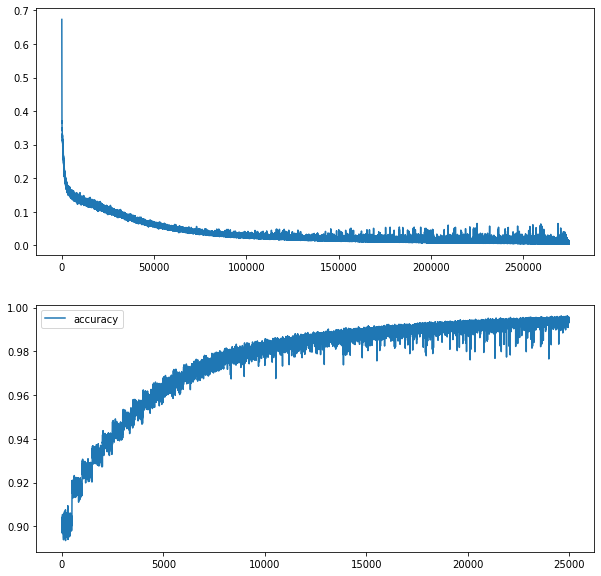

In [ ]:
network1 = train_simple(network1, X, Y, 50, "ConvNet",1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 0, Loss = 0.00017595319214160554
inherrent accuracy = 81.0676 %, prediction accuracy = 99.9884 %


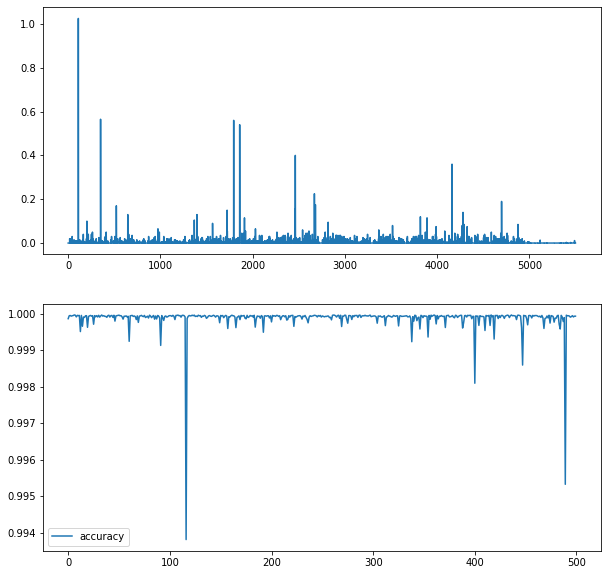

In [ ]:
network1 = train_simple(network1, X, Y, 1, "ConvNet",1,0.01,"cpu",True)

## Prediction of 2 evolution steps

In [ ]:
big_data_2 = Data(frame_shape=(20,20), steps=2, num_frames=300000)
X_2, Y_2 = big_data_2.generator()

  0%|          | 0/300000 [00:00<?, ?it/s]

  0%|          | 0/300000 [00:00<?, ?it/s]

Dataset generation successful!


In [ ]:
network2 = ConvNetwork(100, 2) 

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 0, Loss = 0.15278967961668968
inherrent accuracy = 77.1743 %, prediction accuracy = 90.0797 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 1, Loss = 0.15089798924326897
inherrent accuracy = 77.1743 %, prediction accuracy = 90.1884 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 2, Loss = 0.1494174191057682
inherrent accuracy = 77.1743 %, prediction accuracy = 90.2691 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 3, Loss = 0.1480430849790573
inherrent accuracy = 77.1743 %, prediction accuracy = 90.3259 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 4, Loss = 0.14662569323182106
inherrent accuracy = 77.1743 %, prediction accuracy = 90.4175 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 5, Loss = 0.14549872025847435
inherrent accuracy = 77.1743 %, prediction accuracy = 90.4830 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 6, Loss = 0.1444566203057766
inherrent accuracy = 77.1743 %, prediction accuracy = 90.5483 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 7, Loss = 0.14348570281267167
inherrent accuracy = 77.1743 %, prediction accuracy = 90.6013 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 8, Loss = 0.14269290599226953
inherrent accuracy = 77.1743 %, prediction accuracy = 90.6507 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 9, Loss = 0.14177255859971047
inherrent accuracy = 77.1743 %, prediction accuracy = 90.7150 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 10, Loss = 0.14108029845356942
inherrent accuracy = 77.1743 %, prediction accuracy = 90.7682 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 11, Loss = 0.14031579953432083
inherrent accuracy = 77.1743 %, prediction accuracy = 90.8273 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 12, Loss = 0.139522825717926
inherrent accuracy = 77.1743 %, prediction accuracy = 90.8719 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 13, Loss = 0.13886023765802383
inherrent accuracy = 77.1743 %, prediction accuracy = 90.9274 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 14, Loss = 0.13821715280413627
inherrent accuracy = 77.1743 %, prediction accuracy = 90.9797 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 15, Loss = 0.13762221202254296
inherrent accuracy = 77.1743 %, prediction accuracy = 91.0213 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 16, Loss = 0.13703385293483733
inherrent accuracy = 77.1743 %, prediction accuracy = 91.0473 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 17, Loss = 0.13642349922657013
inherrent accuracy = 77.1743 %, prediction accuracy = 91.1047 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 18, Loss = 0.13586939057707786
inherrent accuracy = 77.1743 %, prediction accuracy = 91.1407 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 19, Loss = 0.13529917934536934
inherrent accuracy = 77.1743 %, prediction accuracy = 91.1673 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 20, Loss = 0.1348722215294838
inherrent accuracy = 77.1743 %, prediction accuracy = 91.2135 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 21, Loss = 0.13439646685123444
inherrent accuracy = 77.1743 %, prediction accuracy = 91.2240 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 22, Loss = 0.13396483181416988
inherrent accuracy = 77.1743 %, prediction accuracy = 91.2817 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 23, Loss = 0.13351690775156022
inherrent accuracy = 77.1743 %, prediction accuracy = 91.3032 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 24, Loss = 0.1331622249186039
inherrent accuracy = 77.1743 %, prediction accuracy = 91.3281 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 25, Loss = 0.13288460052013398
inherrent accuracy = 77.1743 %, prediction accuracy = 91.3657 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 26, Loss = 0.1324310472458601
inherrent accuracy = 77.1743 %, prediction accuracy = 91.3759 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 27, Loss = 0.13224932035803794
inherrent accuracy = 77.1743 %, prediction accuracy = 91.3949 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 28, Loss = 0.1321435793042183
inherrent accuracy = 77.1743 %, prediction accuracy = 91.4242 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 29, Loss = 0.1317305753529072
inherrent accuracy = 77.1743 %, prediction accuracy = 91.4365 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 30, Loss = 0.1316214210242033
inherrent accuracy = 77.1743 %, prediction accuracy = 91.4441 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 31, Loss = 0.13137841488420962
inherrent accuracy = 77.1743 %, prediction accuracy = 91.4825 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 32, Loss = 0.13131041350960732
inherrent accuracy = 77.1743 %, prediction accuracy = 91.5081 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 33, Loss = 0.13107438580691813
inherrent accuracy = 77.1743 %, prediction accuracy = 91.5174 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 34, Loss = 0.130774295181036
inherrent accuracy = 77.1743 %, prediction accuracy = 91.5271 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 35, Loss = 0.1305953741967678
inherrent accuracy = 77.1743 %, prediction accuracy = 91.5334 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 36, Loss = 0.13041016663610935
inherrent accuracy = 77.1743 %, prediction accuracy = 91.5557 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 37, Loss = 0.1302037005275488
inherrent accuracy = 77.1743 %, prediction accuracy = 91.5827 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 38, Loss = 0.13014755162596703
inherrent accuracy = 77.1743 %, prediction accuracy = 91.5801 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 39, Loss = 0.1298477790504694
inherrent accuracy = 77.1743 %, prediction accuracy = 91.6001 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 40, Loss = 0.12983931331336498
inherrent accuracy = 77.1743 %, prediction accuracy = 91.6062 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 41, Loss = 0.1297298117876053
inherrent accuracy = 77.1743 %, prediction accuracy = 91.6224 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 42, Loss = 0.12955355040729047
inherrent accuracy = 77.1743 %, prediction accuracy = 91.6339 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 43, Loss = 0.12947933575510978
inherrent accuracy = 77.1743 %, prediction accuracy = 91.6530 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 44, Loss = 0.12927635863423348
inherrent accuracy = 77.1743 %, prediction accuracy = 91.6512 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 45, Loss = 0.12918539081513883
inherrent accuracy = 77.1743 %, prediction accuracy = 91.6555 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 46, Loss = 0.12898928950726987
inherrent accuracy = 77.1743 %, prediction accuracy = 91.6667 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 47, Loss = 0.12894543643295764
inherrent accuracy = 77.1743 %, prediction accuracy = 91.6927 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 48, Loss = 0.12887305687367917
inherrent accuracy = 77.1743 %, prediction accuracy = 91.6936 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 49, Loss = 0.12877238726615906
inherrent accuracy = 77.1743 %, prediction accuracy = 91.6883 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 50, Loss = 0.12858116853237153
inherrent accuracy = 77.1743 %, prediction accuracy = 91.6961 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 51, Loss = 0.1284594938904047
inherrent accuracy = 77.1743 %, prediction accuracy = 91.7209 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 52, Loss = 0.12833460825681686
inherrent accuracy = 77.1743 %, prediction accuracy = 91.7238 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 53, Loss = 0.12843934299051762
inherrent accuracy = 77.1743 %, prediction accuracy = 91.7298 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 54, Loss = 0.12828061954677106
inherrent accuracy = 77.1743 %, prediction accuracy = 91.7400 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 55, Loss = 0.12818835228681563
inherrent accuracy = 77.1743 %, prediction accuracy = 91.7478 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 56, Loss = 0.128032205209136
inherrent accuracy = 77.1743 %, prediction accuracy = 91.7418 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 57, Loss = 0.12792388132214547
inherrent accuracy = 77.1743 %, prediction accuracy = 91.7601 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 58, Loss = 0.12793001954257488
inherrent accuracy = 77.1743 %, prediction accuracy = 91.7573 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 59, Loss = 0.12777486704289914
inherrent accuracy = 77.1743 %, prediction accuracy = 91.7628 %


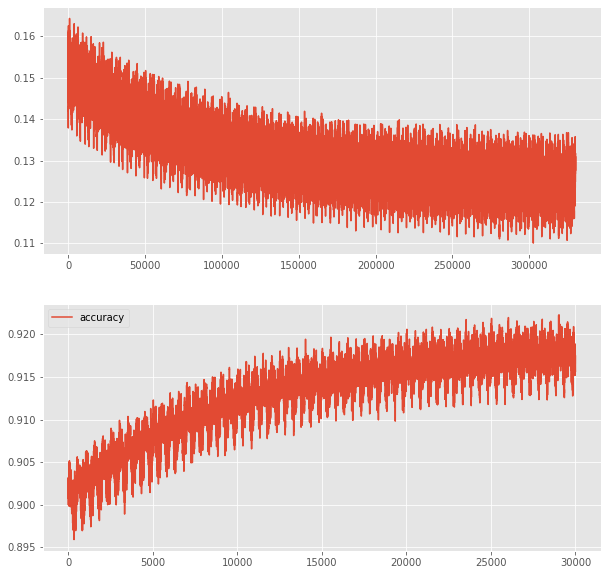

In [ ]:
network2 = train_simple(network2, X_2, Y_2, 60, "ConvNet", steps=2, lr=0.1)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 0, Loss = 0.1521175936162472
inherrent accuracy = 77.1743 %, prediction accuracy = 90.0420 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 1, Loss = 0.15205919340252877
inherrent accuracy = 77.1743 %, prediction accuracy = 90.0465 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 2, Loss = 0.1521423850953579
inherrent accuracy = 77.1743 %, prediction accuracy = 90.0407 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 3, Loss = 0.1521119099855423
inherrent accuracy = 77.1743 %, prediction accuracy = 90.0386 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 4, Loss = 0.1520856354534626
inherrent accuracy = 77.1743 %, prediction accuracy = 90.0465 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 5, Loss = 0.15208041113615037
inherrent accuracy = 77.1743 %, prediction accuracy = 90.0420 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 6, Loss = 0.15210480445623398
inherrent accuracy = 77.1743 %, prediction accuracy = 90.0395 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 7, Loss = 0.15209188720583916
inherrent accuracy = 77.1743 %, prediction accuracy = 90.0388 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 8, Loss = 0.15207711499929427
inherrent accuracy = 77.1743 %, prediction accuracy = 90.0448 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 9, Loss = 0.1521250131726265
inherrent accuracy = 77.1743 %, prediction accuracy = 90.0409 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 10, Loss = 0.1520679682791233
inherrent accuracy = 77.1743 %, prediction accuracy = 90.0414 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 11, Loss = 0.1521327067911625
inherrent accuracy = 77.1743 %, prediction accuracy = 90.0357 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 12, Loss = 0.1521911055445671
inherrent accuracy = 77.1743 %, prediction accuracy = 90.0355 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 13, Loss = 0.15219744607806207
inherrent accuracy = 77.1743 %, prediction accuracy = 90.0295 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 14, Loss = 0.15214238581061362
inherrent accuracy = 77.1743 %, prediction accuracy = 90.0383 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 15, Loss = 0.15210571211576462
inherrent accuracy = 77.1743 %, prediction accuracy = 90.0397 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 16, Loss = 0.1521869215965271
inherrent accuracy = 77.1743 %, prediction accuracy = 90.0364 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 17, Loss = 0.15218323463201522
inherrent accuracy = 77.1743 %, prediction accuracy = 90.0352 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 18, Loss = 0.15210586521029473
inherrent accuracy = 77.1743 %, prediction accuracy = 90.0419 %


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 19, Loss = 0.15216033348441124
inherrent accuracy = 77.1743 %, prediction accuracy = 90.0391 %


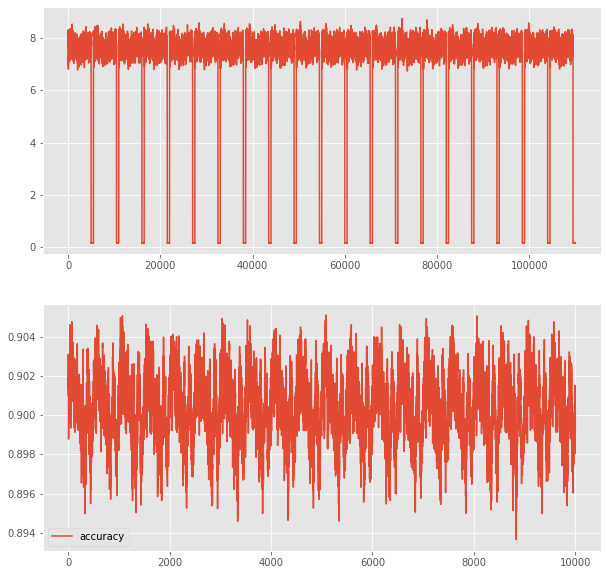

In [ ]:
network2 = train_simple(network2, X_2, Y_2, 20, "ConvNet", steps=2, rounding=True)

In [ ]:
class Test(Data):
  def __init__(self, model, X, Y, steps, ):
    #super(Test, self).__init__()
    if 'torch' in str(type(X)):
      X = X.numpy()
    if 'torch' in str(type(Y)):
      Y = Y.numpy()
    self.model = model.cpu()
    self.X = X[int(len(X)*(275/300)):]
    with torch.no_grad():
      pred = self.model(torch.tensor(self.X).float())
      pred = torch.round(pred)
    self.pred = pred.detach().numpy()
    self.steps = steps
    self.t = Y[int(len(Y)*(275/300)):]


  def reshape_output(self, frame):
    # for step == 1 take away 0 and -1
    # for step == 2 take away 0, 1, -1 and -2
    frames = (frame).copy()
    frames = np.delete(frames,np.linspace(-self.steps, self.steps-1, self.steps*2,dtype=int), 2)
    frames = np.delete(frames,np.linspace(-self.steps, self.steps-1, self.steps*2,dtype=int), 3)
    frames = frames.astype('int')
    
    return frames

  def compare(self, frame_n):
    print((self.X).shape)
    self.X = self.reshape_output(self.X)
    print((self.X).shape)
    X = np.squeeze(self.X)
    pred = np.squeeze(self.pred)
    t = np.squeeze(self.t)
    fig, axs = plt.subplots(2, 2, figsize=(11, 11))
    axs[0,0].imshow(X[frame_n], cmap='viridis', interpolation='nearest')
    axs[0,0].set_title('Initial Frame') 
    
    #plt.subplot(2, 2, 2)
    axs[1,0].imshow(t[frame_n], cmap='viridis', interpolation='nearest')
    axs[1,0].set_title('Test Frame (Computationally Evolved)')
    
    #plt.subplot(2, 2, 3)
    axs[1,1].imshow(pred[frame_n], cmap='viridis', interpolation='nearest')
    axs[1,1].set_title('Predicted Frame (CNN)')
    
    diff = np.subtract(t[frame_n], pred[frame_n])
    diff = np.absolute(diff)
    #plt.subplot(2, 2, 4)
    axs[0,1].imshow(diff, cmap='viridis', interpolation='nearest')
    axs[0,1].set_title('Difference')
    
    plt.show()
    perform = 100*(((t).shape[0]*(t).shape[1]*(self.t).shape[2])-np.sum(np.absolute(np.subtract((t), pred))))/((t).shape[0]*(t).shape[1]*(t).shape[2])
    percent_diff = 100*diff.sum()/(t)[frame_n].sum()
    print(f"Percentage Difference: {percent_diff}%\n")
    print(f"Overall Model Accuracy {perform} %")

  def see_errors(self):
    pred = np.squeeze(self.pred)
    t = np.squeeze(self.t)
    #test_frames = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2])
    sum_y_pred = np.sum(pred, axis=0).flatten().reshape(t[1].shape)
    sum_y = np.sum(t, axis=0).flatten().reshape(t[1].shape)
    plt.imshow(sum_y_pred-sum_y, cmap='hot', interpolation='nearest')
    plt.show()
  
  #def animate(self):



In [ ]:
with torch.no_grad():
  test = torch.tensor(X[int(len(X)*(275/300)):]).float()
  network1 = network1.to("cpu")
  pred = network1(test)
  print(pred.numpy().shape)

(2500, 1, 20, 20)


In [ ]:
example = Data((20,20),1,1)
example = example.spawn()

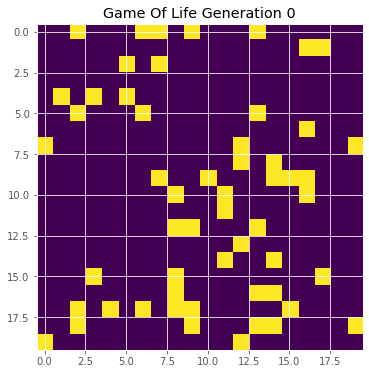

KeyboardInterrupt: ignored

In [ ]:
plt.style.use('ggplot')
def live_plotter(mat,mat1,gen,identifier='',pause_time=0.001):
  if mat1==[]:
    # this is the call to matplotlib that allows dynamic plotting
    plt.ion()
    fig = plt.figure(figsize=(13,6))
    ax = fig.add_subplot(111)
    # create a variable for the line so we can later update it
    mat1 = ax.imshow(mat)        
    #update plot label/title
    plt.title('{} Generation {}'.format(identifier,gen))
    plt.show()
  
  # after the figure, axis, and line are created, we only need to update the y-data
  mat1.set_data(mat)
  # adjust limits if new data goes beyond bounds
  # this pauses the data so the figure/axis can catch up - the amount of pause can be altered above
  plt.pause(pause_time)
  
  # return line so we can update it again in the next iteration
  return mat1

mat1 = []
gen = 0
while True:
  mat1 = live_plotter(example,mat1, gen,'Game Of Life')
  example = evolve(example)
  gen+=1




In [ ]:
test1 = Test(network1, X, Y, 1)

NameError: ignored

In [ ]:
test1.compare(48
55)

SyntaxError: ignored

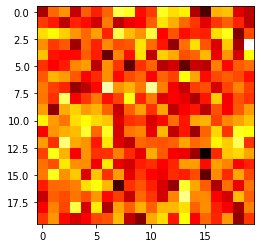

In [ ]:
test1.see_errors()

In [ ]:
test2 = Test(network2, X_2,Y_2,2)

(25000, 1, 20, 20)
(25000, 1, 16, 16)


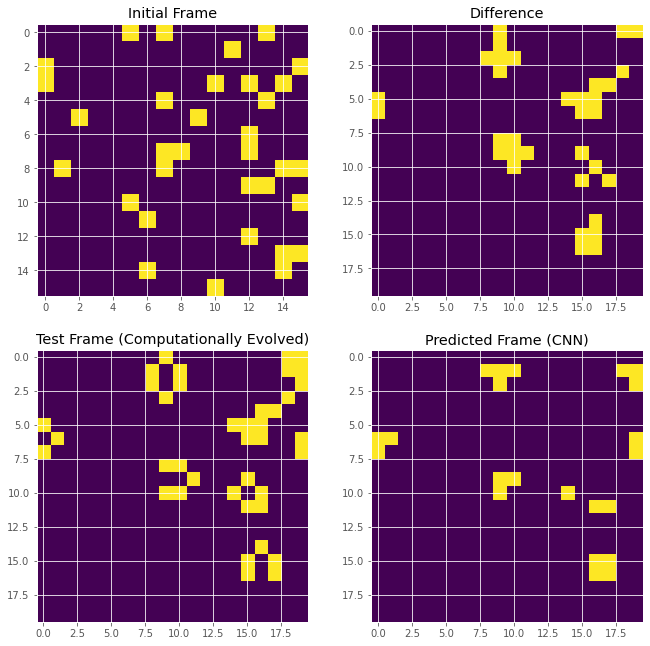

Percentage Difference: 84.61538461538461%

Overall Model Accuracy 92.31789 %


In [ ]:
test2.compare(5)

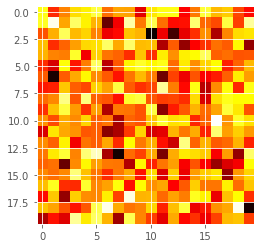

In [ ]:
test2.see_errors()

In [ ]:
def reshape_output(X, steps=1):
    frames = X.copy()
    frames = frames.reshape(frames.shape[0], frames.shape[1]-steps*2, frames.shape[2]-steps*2)
    frames = frames.astype('int')
    return frames

def step(frame, steps):
  frame = frame.astype(int)
  for i in range(steps):
      frame = evolve(frame)
  return frame.astype(int)

  def torus(X):
    return self.reshape_input(np.array([
        np.pad(x.reshape(self.frame_shape), (self.steps,self.steps), mode = 'wrap')
        for x in X
    ]))

def compare(pred, test, init, frame_n):
    fig, axs = plt.subplots(3, 2, figsize=(11, 11))
    axs[0,0].imshow(init[frame_n], cmap='viridis', interpolation='nearest')
    axs[0,0].set_title('Initial Frame') 
    
    #plt.subplot(2, 2, 2)
    axs[1,0].imshow(test[frame_n], cmap='viridis', interpolation='nearest')
    axs[1,0].set_title('Test Frame (Computationally Evolved)')
    
    #plt.subplot(2, 2, 3)
    axs[1,1].imshow(pred[frame_n], cmap='viridis', interpolation='nearest')
    axs[1,1].set_title('Predicted Frame (CNN)')
    
    diff = np.subtract(test[frame_n], pred[frame_n])
    diff = np.absolute(diff)
    #plt.subplot(2, 2, 4)
    axs[0,1].imshow(diff, cmap='viridis', interpolation='nearest')
    axs[0,1].set_title('Difference')
    
    axs[2,1].axis('off')
    
    plt.show()
    perform = 100*((test.shape[0]*test.shape[1]*test.shape[2])-np.sum(np.absolute(np.subtract(test, pred))))/(test.shape[0]*test.shape[1]*test.shape[2])
    percent_diff = 100*diff.sum()/test[frame_n].sum()
    print(f"Percentage Difference: {percent_diff}%\n")
    print(f"Overall Model Accuracy {perform} %")
    
def best(pred, test):
    best_frames = []
    for frame_n in range(test.shape[0]):
        diff = np.subtract(test[frame_n], pred[frame_n
                                              ])
        diff = np.absolute(diff)
        percent_diff = 100*diff.sum()/test[frame_n].sum()
        weighted_diff = (np.sum(pred[frame_n])**2-diff.sum()**2)
        best_frames.append((frame_n, percent_diff, weighted_diff))
    best_frames = pd.DataFrame(data=best_frames, columns=['frame_n','percent_diff', 'weighted_diff'])
    best_frames = best_frames.sort_values('weighted_diff', ascending=False)
    print(best_frames.head(5))
    print(f"Average percentage difference = {best_frames['percent_diff'].mean()}") 
    print(f"Frame {best_frames['percent_diff'].max()} had the best prediction (lowest percentage difference)")

def see_errors(model, X, y):
    y_pred = model.predict_classes(X)
    #test_frames = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2])
    sum_y_pred = np.sum(y_pred, axis=0).flatten().reshape(y[1].shape)
    sum_y = np.sum(y, axis=0).flatten().reshape(y[1].shape)
    plt.imshow(sum_y_pred-sum_y, cmap='hot', interpolation='nearest')
    plt.show()
    
def step_by_step(X, pred, steps, frame_n):
    if steps>=2:
        
        fig, axs = plt.subplots(1,2+steps, figsize = (11,11))
        axs[0].imshow(X[frame_n], cmap='viridis', interpolation='nearest')
        axs[0].set_title('Generation 0')
        
        for s in range(1, steps+1):
            axs[s].imshow(step(X[frame_n], s), cmap='viridis', interpolation='nearest')
            axs[s].set_title(f'Generation {s}')
        
        axs[steps+1].imshow(pred[frame_n], cmap='viridis', interpolation='nearest')
        axs[steps+1].set_title(f'Prediction of Generation {steps}')
        
        #introduce difference between middle generations in order to see the workings of the algorithm
        
        


def reshapone(f):
    return f.reshape(f.shape[0], f.shape[1], 1)

def tester (model, X, X_unp, y, steps, frame_n, dev="cuda"):
    fig, axs = plt.subplots(13,2+steps, figsize = (50, 50))
    fig.tight_layout()
    X_test = X[int(len(X)*(275/300)):]
    y_pred = model(torch.tensor(X_test, device=dev))
    y_pred = y_pred().cpu().detach()
    if steps>=2:
        
        axs[0,0].imshow(X[frame_n], cmap='viridis', interpolation='nearest')
        axs[0,0].set_title('Random Gen 0')
        
        for s in range(1, steps+1):
            ystep = step(X_unp[frame_n], s)
            axs[0,s].imshow(ystep, cmap='viridis', interpolation='nearest')
            axs[0,s].set_title(f'Random Gen {s}')
            
            
            diff = np.subtract(ystep, y_pred[frame_n])
            diff = np.absolute(diff)
            
            axs[1,s].imshow(diff, cmap='viridis', interpolation='nearest')
            axs[1,s].set_title(f'Difference = {np.sum(diff)}')
            
            
        
        axs[0,steps+1].imshow(y_pred[frame_n], cmap='viridis', interpolation='nearest')
        axs[0,steps+1].set_title(f'Prediction of Random Gen {steps}')
        

        
        
    axs[1,steps+1].axis('off')
    axs[1,0].axis('off')
    axs[4,steps+1].axis('off')
    axs[4,0].axis('off')
    axs[6,steps+1].axis('off')
    axs[6,0].axis('off')
    axs[8,steps+1].axis('off')
    axs[8,0].axis('off')
    axs[10,steps+1].axis('off')
    axs[10,0].axis('off')
    
    
    podium_ = shape_maker(20, 20, podium)
    acorn_ = shape_maker(20, 20, acorn)
    space_ship_ = shape_maker(20, 20, space_ship)
    signpost_ = shape_maker(20, 20, signpost)
    
    shapes = np.array([
    podium_, 
    acorn_,
    space_ship_,
    signpost_,
    ]).astype(int)
    
    print(f"shapes shape: {shapes.shape}")
    
    shapes_ = torus(shapes, steps=2)
    print(f"shapes shape: {shapes_.shape}")
    shapes_pred = model.predict_classes(shapes_)
    print(f"shapes_pred shape: {shapes_pred.shape}")
    
    axs[3,0].imshow(podium_, cmap='viridis', interpolation='nearest')
    axs[3,0].set_title('Podium Gen 0')
    
    shapes_pred = reshape_output(shapes_pred, steps = 0)
    
    for s in range(1, steps+1):
        ystep = step(podium_, s)
        axs[3,s].imshow(ystep, cmap='viridis', interpolation='nearest')
        axs[3,s].set_title(f'Podium Gen {s}')
        diff = np.subtract(ystep, shapes_pred[0])
        diff = np.absolute(diff)
        axs[4,s].imshow(diff, cmap='viridis', interpolation='nearest')
        axs[4,s].set_title(f'Difference = {np.sum(diff)}')
            
    axs[3,steps+1].imshow(shapes_pred[0], cmap='viridis', interpolation='nearest')
    axs[3,steps+1].set_title(f'Prediction of podium Gen {steps}')
    

    axs[5,0].imshow(acorn_, cmap='viridis', interpolation='nearest')
    axs[5,0].set_title('Acorn Gen 0')
        
    for s in range(1, steps+1):
        ystep = step(acorn_, s)
        axs[5,s].imshow(ystep, cmap='viridis', interpolation='nearest')
        axs[5,s].set_title(f'Acorn Gen {s}')
        diff = np.subtract(ystep, shapes_pred[1])
        diff = np.absolute(diff)
        axs[6,s].imshow(diff, cmap='viridis', interpolation='nearest')
        axs[6,s].set_title(f'Difference = {np.sum(diff)}')
            
    axs[5,steps+1].imshow(shapes_pred[1], cmap='viridis', interpolation='nearest')
    axs[5,steps+1].set_title(f'Prediction of Acorn Gen {steps}')
    
    axs[7,0].imshow(space_ship_, cmap='viridis', interpolation='nearest')
    axs[7,0].set_title('Space Ship Gen 0')
        
    for s in range(1, steps+1):
        ystep = step(space_ship_, s)
        axs[7,s].imshow(ystep, cmap='viridis', interpolation='nearest')
        axs[7,s].set_title(f'Space Ship Gen {s}')
        diff = np.subtract(ystep, shapes_pred[2])
        diff = np.absolute(diff)
        axs[8,s].imshow(diff, cmap='viridis', interpolation='nearest')
        axs[8,s].set_title(f'Difference = {np.sum(diff)}')
            
    axs[7,steps+1].imshow(shapes_pred[2], cmap='viridis', interpolation='nearest')
    axs[7,steps+1].set_title(f'Prediction of Space Ship Gen {steps}')
    
    
    axs[9,0].imshow(signpost_, cmap='viridis', interpolation='nearest')
    axs[9,0].set_title('Signpost Gen 0')
        
    for s in range(1, steps+1):
        ystep = step(signpost_, s)
        axs[9,s].imshow(ystep, cmap='viridis', interpolation='nearest')
        axs[9,s].set_title(f'Signpost Gen {s}')
        diff = np.subtract(ystep, shapes_pred[3])
        diff = np.absolute(diff)
        axs[10,s].imshow(diff, cmap='viridis', interpolation='nearest')
        axs[10,s].set_title(f'Difference = {np.sum(diff)}')
            
    axs[9,steps+1].imshow(shapes_pred[3], cmap='viridis', interpolation='nearest')
    axs[9,steps+1].set_title(f'Prediction of Signpost Gen {steps}')
    
    for s in range(steps+2):
        axs[2,s].axis('off')        
        axs[11,s].axis('off')
    
    for s in range(1, steps+2):
        axs[12,s].axis('off')
    

    

    #test_frames = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2])
    sum_y_pred = np.sum(y_pred, axis=0).flatten().reshape(y[1].shape)
    sum_y = np.sum(y, axis=0).flatten().reshape(y[1].shape)
    axs[12,0].imshow(sum_y_pred-sum_y, cmap='hot', interpolation='nearest')
    axs[12,0].set_title('Error Map')
    
    plt.show()
    perform = 100*((y.shape[0]*y.shape[1]*y.shape[2])-np.sum(np.absolute(np.subtract(y, y_pred))))/(y.shape[0]*y.shape[1]*y.shape[2])
    percent_diff = 100*diff.sum()/y[frame_n].sum()
    print(f"Percentage Difference: {percent_diff}%\n")
    print(f"Overall Model Accuracy {perform} %")
    
    best(y_pred, y)
    


In [ ]:

'''
input_shape = (X_train.shape[1], X_train.shape[2], 1)

jewel2 = keras.Sequential()
jewel2.add(Conv2D(
        filters=50,
        kernel_size=(3, 3),
        padding='same',
        activation='relu',
        strides=1,
        input_shape=(input_shape)
))
jewel2.add(Dense(100))
jewel2.add(Dense(1))
jewel2.add(Activation('sigmoid'))


jewel2.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
jewel2.summary()
'''

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 20, 50)        500       
_________________________________________________________________
dense (Dense)                (None, 20, 20, 100)       5100      
_________________________________________________________________
dense_1 (Dense)              (None, 20, 20, 1)         101       
_________________________________________________________________
activation (Activation)      (None, 20, 20, 1)         0         
Total params: 5,701
Trainable params: 5,701
Non-trainable params: 0
_________________________________________________________________


## Training Function
### run this cell and call the function in a separate cell to train the model.

In [ ]:
def trainer(model, X_train, y_train, X_val, y_val, batch_size=50, epochs=2, patience=2, filename_suffix=''):
    early_stopping = keras.callbacks.EarlyStopping(
            min_delta=0.001,
            patience=patience,
            restore_best_weights=True)
    history = model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              batch_size=batch_size,
              epochs=epochs,
              callbacks=[early_stopping],
    )
    '''
    with open('{}_model{}.json'.format(model, filename_suffix), 'w') as file:
        file.write(model.to_json())
    model.save_weights('{}_model{}.h5'.format(model, filename_suffix))
    '''
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
    history_df.loc[:, ['loss', 'val_loss']].plot()



In [ ]:
trainer(model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=5, filename_suffix='_basic')

In [ ]:
y_pred = jewel2.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Population: 42


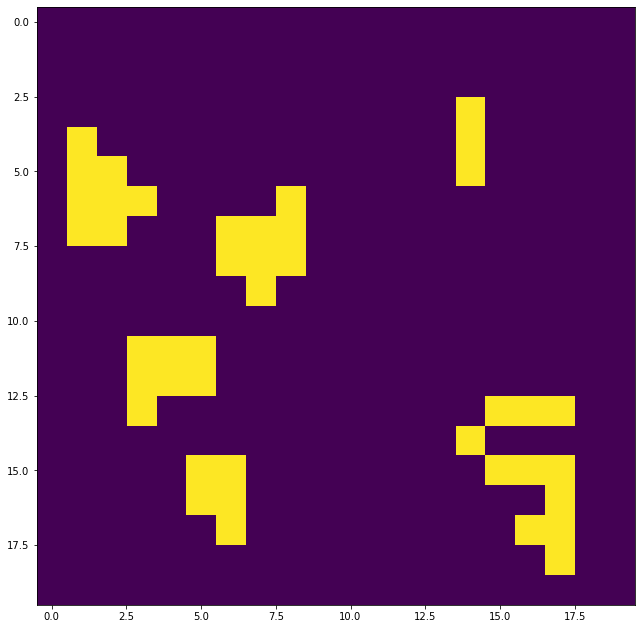

In [ ]:


pred_frames = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], y_pred.shape[2])
pred_frames = pred_frames.astype('int')
watch_world(pred_frames[5])

Population: 39


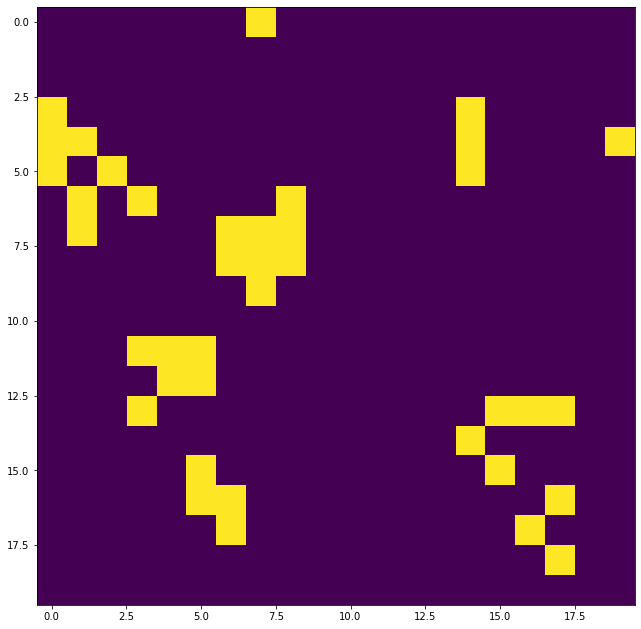

In [ ]:
test_frames = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2])
test_frames = test_frames.astype('int')
watch_world(test_frames[5])


Population: 55


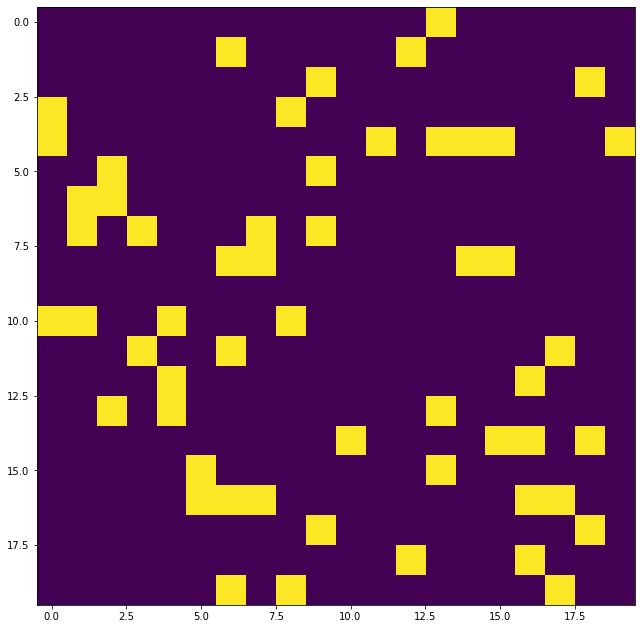

In [ ]:

init_frames = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
init_frames = init_frames.astype('int')
init_frames[1]
watch_world(init_frames[5])

In [ ]:

cube = np.array(
         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

line = np.array(
         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

podium = np.array(
         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

glider = np.array(
         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
          [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

signpost = np.array(
         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
          [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

space_ship = np.array(
         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
          [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
          [0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

acorn = np.array(
         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [0, 1, 1, 0, 0, 1, 1, 1, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

def shape_maker(rows, cols, square):
    world = np.zeros([rows, cols])
    lower_center = int((world.shape[1]/2)-square.shape[1]/2)
    upper_center = int((world.shape[1]/2)+square.shape[1]/2)
    world[upper_center-2*int(square.shape[0]/2):upper_center, upper_center-2*int(square.shape[0]/2):upper_center] += square
    return world


In [ ]:
signpostt=shape_maker(20,20,podium)
signpostt.shape

(20, 20)

In [ ]:
shapes = np.array([
    cube, 
    line,
    podium, 
    signpost,
    acorn,
    space_ship,
    glider,
    ]).astype(int)


## Post-training Functions
### These functions summarize the performance of the model and compare the predictions of the model with the test-data. The reshape_output function is needed in order to visualize the model predictions while the torus function wraps the world-matrix into a torus.

In [ ]:
compare(pred_frames, test_frames, init_frames, 10360)

NameError: ignored

In [ ]:
#test_frames.shape[0]

In [ ]:
best(pred_frames, test_frames)

In [ ]:
see_errors(jewel2, X_test, y_test)
    

In [ ]:
X_train[1].shape[0]

In [ ]:

X_train_pad = torus(X_train)
X_val_pad = torus(X_val)
X_test_pad = torus(X_test)



In [ ]:
X_train_pad.shape

In [ ]:
frame_shape

## Jewel3 - Model N2
### Jewel3 is an improved version of Jewel2. This model differs from the previous one in that it is padded. The unevolved world-matrix has been wrapped into a toroid so all opposite sides of the matrix are connected. the edges of the kernel are padded 

In [ ]:


input_shape = (X_train_pad.shape[1]+2, X_train_pad.shape[2]+2, 1)

jewel3 = keras.Sequential()
jewel3.add(Conv2D(
        filters=50,
        kernel_size=(3, 3),
        padding='valid',
        activation='relu',
        strides=1,
        input_shape=(input_shape)
))
jewel3.add(Dense(100))
jewel3.add(Dense(1))
jewel3.add(Activation('sigmoid'))


jewel3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
jewel3.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 22, 22, 50)        500       
_________________________________________________________________
dense_34 (Dense)             (None, 22, 22, 100)       5100      
_________________________________________________________________
dense_35 (Dense)             (None, 22, 22, 1)         101       
_________________________________________________________________
activation_17 (Activation)   (None, 22, 22, 1)         0         
Total params: 5,701
Trainable params: 5,701
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
2000/2000 [==============================] - 33s 16ms/step - loss: 0.0118 - accuracy: 0.9969 - val_loss: 1.3116e-04 - val_accuracy: 1.0000
Epoch 2/5
2000/2000 [==============================] - 34s 17ms/step - loss: 4.8719e-05 - accuracy: 1.0000 - val_loss: 1.5574e-05 - val_accuracy: 1.0000
Epoch 3/5
2000/2000 [==============================] - 34s 17ms/step - loss: 8.1006e-06 - accuracy: 1.0000 - val_loss: 3.7741e-06 - val_accuracy: 1.0000
Epoch 4/5
2000/2000 [==============================] - 33s 17ms/step - loss: 2.1256e-06 - accuracy: 1.0000 - val_loss: 1.0795e-06 - val_accuracy: 1.0000
Epoch 5/5
2000/2000 [==============================] - 35s 17ms/step - loss: 6.3096e-07 - accuracy: 1.0000 - val_loss: 3.3640e-07 - val_accuracy: 1.0000


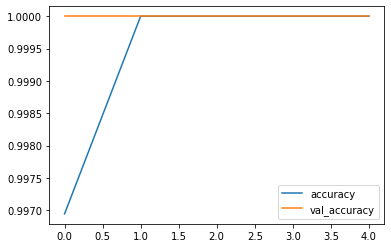

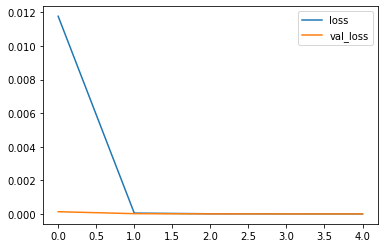

In [ ]:
trainer(model=jewel3, X_train=X_train_pad, y_train=y_train, X_val=X_val_pad, y_val=y_val, epochs=5, filename_suffix='_padded')

In [ ]:
pred2 = jewel3.predict_classes(X_test_pad)

In [ ]:
pred2.shape
pred_2_frames = reshape_output(pred2)

In [ ]:
compare(pred_2_frames, test_frames, init_frames, 10360)

NameError: name 'pred_2_frames' is not defined

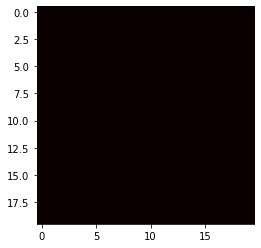

In [ ]:
see_errors(jewel3, X_test_pad, y_test)

In [ ]:
X_train_4, y_train_4 = data_generator(100000, 2, 20, 20)

In [ ]:
X_val_4, y_val_4 = data_generator(10000, 2, 20, 20)

In [ ]:
X_test_4, y_test_4 = data_generator(20000, 2, 20, 20)

In [ ]:
X_train_4_pad = torus(X_train_4, frame_shape=(20,20), steps=2)
X_val_4_pad = torus(X_val_4, frame_shape=(20,20), steps=2)
X_test_4_pad = torus(X_test_4, frame_shape=(20,20), steps=2)
#y_train_4_pad = torus(y_train_4, frame_shape=(20,20), steps=2)
#y_val_4_pad = torus(y_val_4, frame_shape=(20,20), steps=2)
#y_test_4_pad = torus(y_test_4, frame_shape=(20,20), steps=2)


In [ ]:
X_train_4_pad.shape

(100000, 24, 24, 1)

In [ ]:
frame_shape[0]+2

22

In [ ]:
y_train_4_pad.shape

(100000, 24, 24, 1)

## Jewel4 - Model N3
### This model is an attempt to predict 2 steps into the future rather than 1. in order to predict further into the future a larger kernel is required. the size of the kernel square increases linearly with the number of steps.   

In [ ]:
input_shape = (frame_shape[0]+4, frame_shape[1]+4, 1)

jewel4 = keras.Sequential(name='jewel4')
jewel4.add(Conv2D(
        filters=50,
        kernel_size=(5, 5),
        padding='valid',
        activation='relu',
        strides=1,
        input_shape=(input_shape)
))

jewel4.add(Dense(100))
jewel4.add(Dense(1))
jewel4.add(Activation('sigmoid'))


jewel4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
jewel4.summary()


Model: "jewel4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 20, 20, 50)        1300      
_________________________________________________________________
dense_148 (Dense)            (None, 20, 20, 100)       5100      
_________________________________________________________________
dense_149 (Dense)            (None, 20, 20, 1)         101       
_________________________________________________________________
activation_73 (Activation)   (None, 20, 20, 1)         0         
Total params: 6,501
Trainable params: 6,501
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
2000/2000 [==============================] - 55s 28ms/step - loss: 0.1820 - accuracy: 0.9093 - val_loss: 0.1383 - val_accuracy: 0.9168
Epoch 2/10
2000/2000 [==============================] - 53s 26ms/step - loss: 0.1432 - accuracy: 0.9163 - val_loss: 0.1389 - val_accuracy: 0.9173
Epoch 3/10
2000/2000 [==============================] - 53s 27ms/step - loss: 0.1380 - accuracy: 0.9183 - val_loss: 0.1375 - val_accuracy: 0.9193


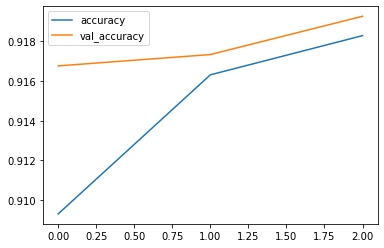

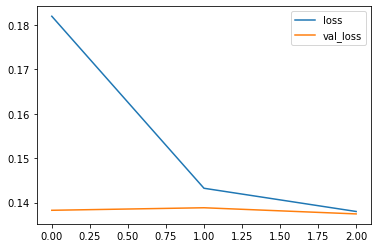

In [ ]:
trainer(model=jewel4, X_train=X_train_4_pad, y_train=y_train_4, X_val=X_val_4_pad, y_val=y_val_4, epochs=10, filename_suffix='')

In [ ]:
pred4 = jewel4.predict_classes(X_test_4_pad)

In [ ]:
pred4.shape


(20000, 20, 20, 1)

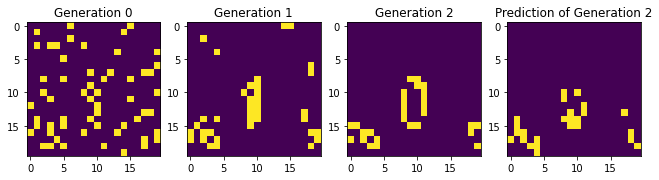

In [ ]:
step_by_step(X=X_test_4, pred=pred4, steps=2, frame_n=1000)


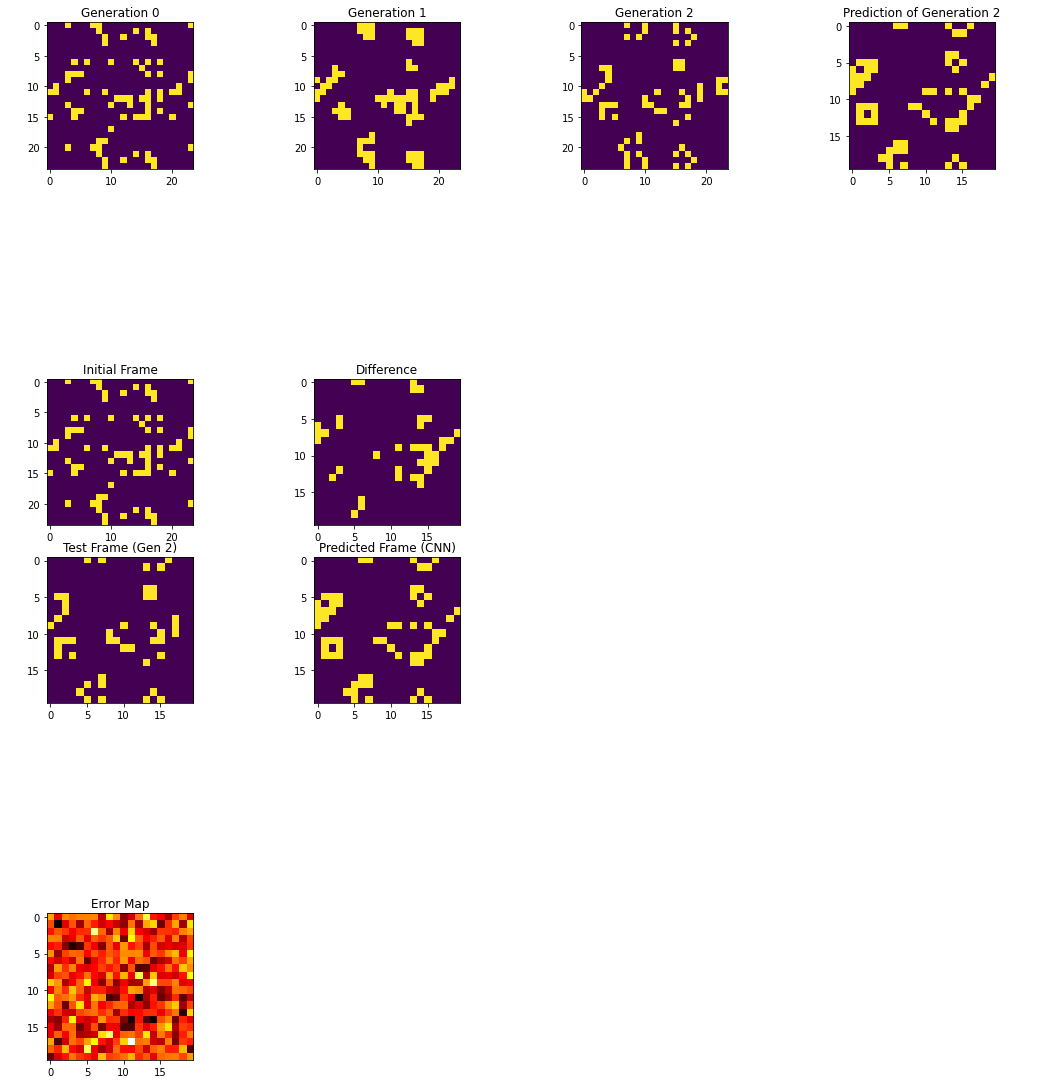

Percentage Difference: 86.66666666666667%

Overall Model Accuracy 94.2347375 %
       frame_n  percent_diff  weighted_diff
5995      5995     47.368421           2407
15554    15554     45.652174           2368
15232    15232     86.666667           2323
17817    17817     47.169811           2291
3881      3881     46.428571           2240
Average percentage difference = 67.56397305671663
Frame 225.0 had the best prediction (lowest percentage difference)


In [ ]:
tester(model=jewel4, X=X_test_4_pad, y=y_test_4, pred=pred4, steps=2, frame_n=15232)

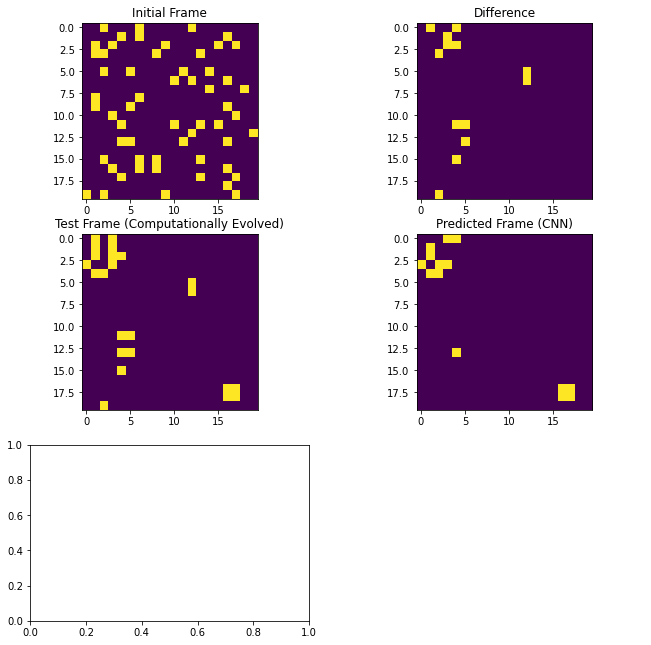

Percentage Difference: 56.52173913043478%

Overall Model Accuracy 94.2347375 %


In [ ]:
compare(pred4, y_test_4, X_test_4, )

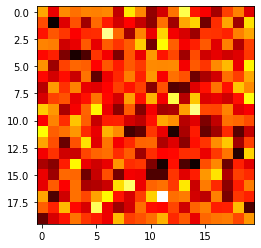

In [ ]:
see_errors(jewel4, X_test_4_pad, y_test_4)

In [ ]:
def master(model, steps, rows, cols, epochs=10):
    
    X_train, y_train = data_generator(100000*int(20/((cols*rows)**0.5)))
    X_val, y_val = data_generator(10000*int(20/((cols*rows)**0.5)), steps, rows, cols)
    X_test, y_test = data_generator(20000*int(20/((cols*rows)**0.5)), steps, rows, cols)
    print('Data generation complete.')
    
    
    X_train_pad = torus(X_train, frame_shape=(rows, cols), steps=steps)
    X_val_pad = torus(X_val, frame_shape=(rows, cols), steps=steps)
    X_test_pad = torus(X_test, frame_shape=(rows, cols), steps=steps)
    print('Padding complete.')
    
    trainer(model=model, X_train=X_train_pad, y_train=y_train, X_val=X_val_pad, y_val=y_val, epochs=10, filename_suffix='')
    
                        
def builder(steps, rows, cols):
    
    X_train, y_train = data_generator(100000)
    X_val, y_val = data_generator(10000)
    X_test, y_test = data_generator(20000)
    print('Data generation complete.')
    
    
    X_train_pad = torus(X_train, frame_shape=(rows, cols), steps=steps)
    X_val_pad = torus(X_val, frame_shape=(rows, cols), steps=steps)
    X_test_pad = torus(X_test, frame_shape=(rows, cols), steps=steps)
    print('Padding complete.')
    
    return X_train, y_train, X_train_pad, X_val, y_val, X_val_pad, X_test, y_test, X_test_pad
    
    
    
    

In [ ]:
y_test_4[1].shape

(20, 20, 1)

In [ ]:
jewel4 = keras.Sequential(name='jewel4')
jewel4.add(Conv2D(
        filters=50,
        kernel_size=(5, 5),
        padding='valid',
        activation='relu',
        strides=1,
        input_shape=(input_shape)
))

jewel4.add(Dense(100))
jewel4.add(Dense(1))
jewel4.add(Activation('sigmoid'))


jewel4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
jewel4.summary()

Model: "jewel4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 20, 20, 50)        1300      
_________________________________________________________________
dense_142 (Dense)            (None, 20, 20, 100)       5100      
_________________________________________________________________
dense_143 (Dense)            (None, 20, 20, 1)         101       
_________________________________________________________________
activation_70 (Activation)   (None, 20, 20, 1)         0         
Total params: 6,501
Trainable params: 6,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
jewel5 = keras.Sequential(name='Jewel5')
jewel5.add(Conv2D(
    filters=50,
    kernel_size=(3, 3),
    padding='valid',
    activation='relu',
    strides=1,
    input_shape=((24,24,1))
))

jewel5.add(Dense(100))
jewel5.add(Dense(1))
jewel5.add(Activation('sigmoid'))

jewel5.add(Conv2D(
    filters=50,
    kernel_size=(3, 3),
    padding='valid',
    activation='relu',
    strides=1,
    input_shape=((24,24,1))
))

jewel5.add(Dense(100))
jewel5.add(Dense(1))
jewel5.add(Activation('sigmoid'))

jewel5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
jewel5.summary()

Model: "Jewel5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 22, 22, 50)        500       
_________________________________________________________________
dense_150 (Dense)            (None, 22, 22, 100)       5100      
_________________________________________________________________
dense_151 (Dense)            (None, 22, 22, 1)         101       
_________________________________________________________________
activation_74 (Activation)   (None, 22, 22, 1)         0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 20, 20, 50)        500       
_________________________________________________________________
dense_152 (Dense)            (None, 20, 20, 100)       5100      
_________________________________________________________________
dense_153 (Dense)            (None, 20, 20, 1)         101  

In [ ]:
X_train_5, y_train_5, X_train_pad_5, X_val_5, y_val_5, X_val_pad_5, X_test_5, y_test_5, X_test_pad_5 = builder(steps=2, rows=20, cols=20)

Data generation complete.
Padding complete.


In [ ]:
X_train_pad_5.shape

(100000, 24, 24, 1)

In [ ]:
trainer(model=jewel4, X_train=X_train_pad_5, y_train=y_train_5, X_val=X_val_pad_5, y_val=y_val_5, epochs=10, filename_suffix='')

Epoch 1/10
2000/2000 [==============================] - 54s 27ms/step - loss: 0.0177 - accuracy: 0.9953 - val_loss: 0.8881 - val_accuracy: 0.9090
Epoch 2/10
 716/2000 [=========>....................] - ETA: 30s - loss: 2.9269e-04 - accuracy: 1.0000- ETA: 31s - loss: 2.9593e-04 - accuracy

KeyboardInterrupt: 

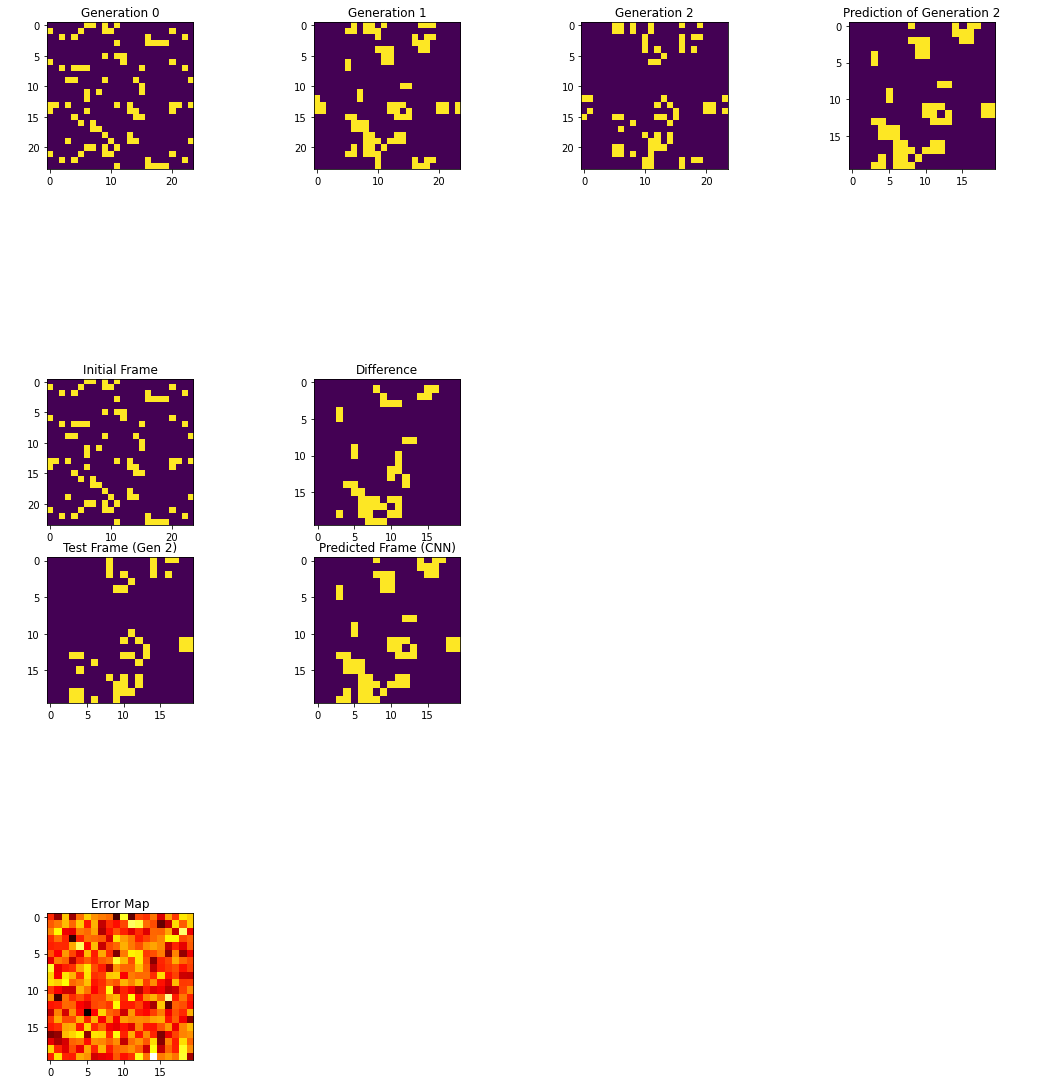

Percentage Difference: 100.0%

Overall Model Accuracy 90.89795 %
       frame_n  percent_diff  weighted_diff
9            9     74.468085           1911
6206      6206     58.823529           1909
10887    10887    100.000000           1908
7895      7895     63.793103           1880
17337    17337     66.071429           1880
Average percentage difference = 108.4695398234616
Frame 344.44444444444446 had the best prediction (lowest percentage difference)


In [ ]:
tester(model=jewel5, X=X_test_pad_5, y=y_test_5, pred=pred5, steps=2, frame_n=10887)

Epoch 1/10
2000/2000 [==============================] - 74s 37ms/step - loss: 0.1075 - accuracy: 0.9493 - val_loss: 0.0847 - val_accuracy: 0.9572
Epoch 2/10
2000/2000 [==============================] - 83s 42ms/step - loss: 0.0838 - accuracy: 0.9579 - val_loss: 0.0836 - val_accuracy: 0.9580
Epoch 3/10
2000/2000 [==============================] - 84s 42ms/step - loss: 0.0833 - accuracy: 0.9581 - val_loss: 0.0833 - val_accuracy: 0.9583
Epoch 4/10
2000/2000 [==============================] - 81s 40ms/step - loss: 0.0830 - accuracy: 0.9583 - val_loss: 0.0831 - val_accuracy: 0.9583


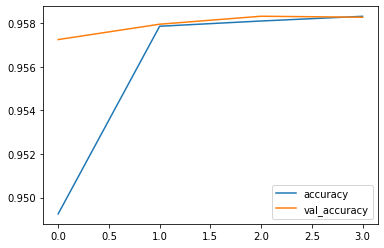

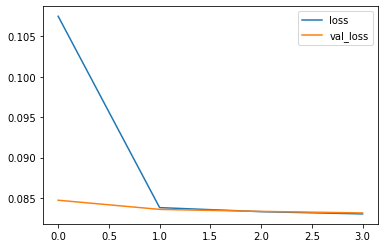

In [ ]:
trainer(model=jewel5, X_train=X_train_4_pad, y_train=y_train_4, X_val=X_val_4_pad, y_val=y_val_4, epochs=10, filename_suffix='')

In [ ]:
pred5 = jewel5.predict_classes(X_test_pad_5)

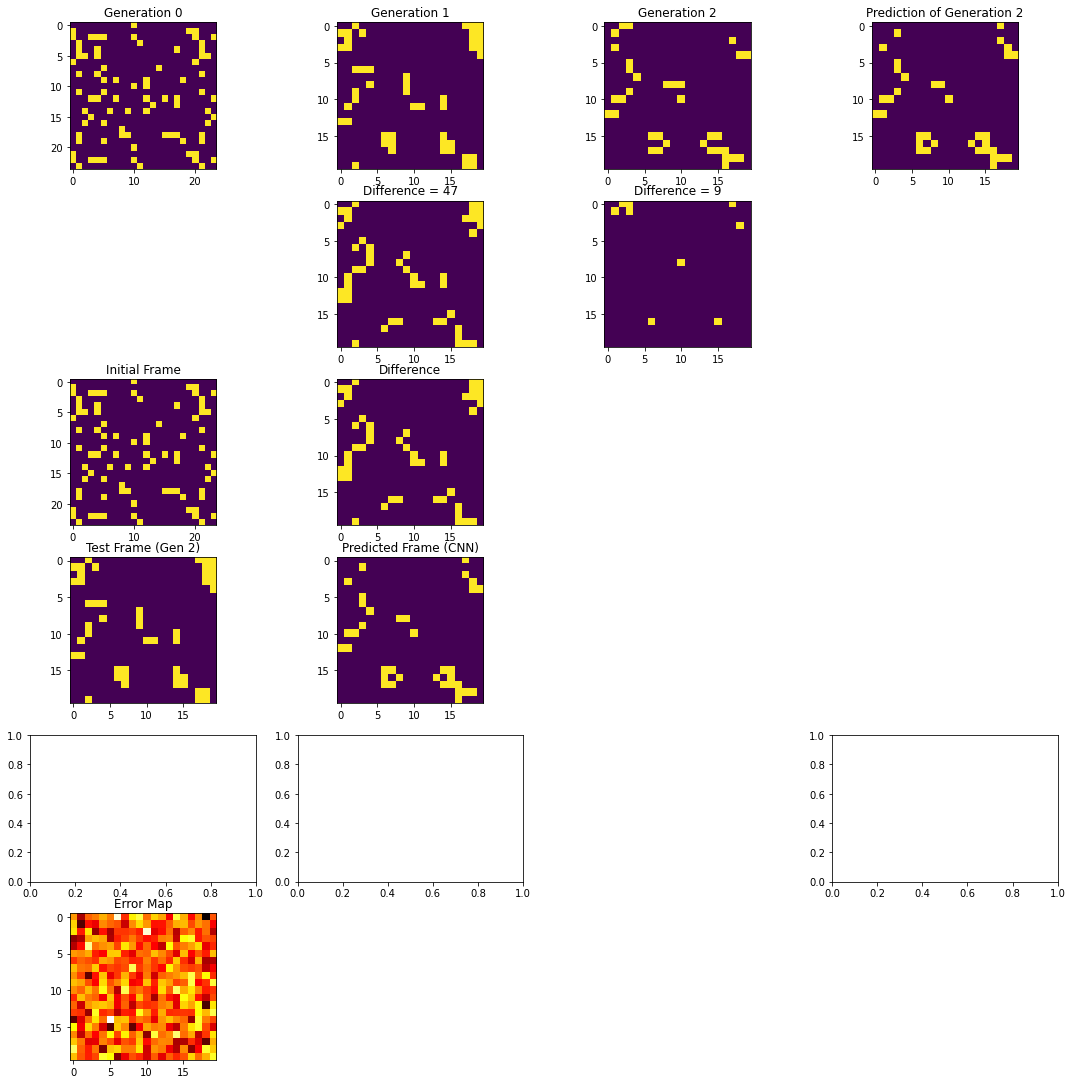

Percentage Difference: 97.91666666666667%

Overall Model Accuracy 90.0889625 %
       frame_n  percent_diff  weighted_diff
15002    15002     67.272727           2727
11399    11399     61.702128           2075
14963    14963     77.192982           2033
12293    12293     92.727273           2023
19317    19317     80.000000           2000
Average percentage difference = 98.02653279554416
Frame 171.875 had the best prediction (lowest percentage difference)


In [ ]:
tester(model=jewel5, X=X_test_pad_5,X_unp=X_test_5, y=y_test_5, pred=pred5, steps=2, frame_n=10887)

In [ ]:
jewel6 = keras.Sequential(name='Jewel5')
jewel6.add(Conv2D(
    filters=50,
    kernel_size=(5, 5),
    padding='valid',
    activation='relu',
    strides=1,
    input_shape=((24,24,1))
))

jewel6.add(Dense(100))
jewel6.add(Dense(1))
jewel6.add(Activation('sigmoid'))


jewel6.add(Conv2D(
    filters=50,
    kernel_size=(5, 5),
    padding='same',
    activation='relu',
    strides=1,
))

jewel6.add(Dense(100))
jewel6.add(Dense(1))
jewel6.add(Activation('sigmoid'))

jewel6.add(Conv2D(
    filters=50,
    kernel_size=(5, 5),
    padding='same',
    activation='relu',
    strides=1,
))

jewel6.add(Dense(100))
jewel6.add(Dense(1))
jewel6.add(Activation('sigmoid'))

jewel6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
jewel6.summary()

Model: "Jewel5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 20, 20, 50)        1300      
_________________________________________________________________
dense_22 (Dense)             (None, 20, 20, 100)       5100      
_________________________________________________________________
dense_23 (Dense)             (None, 20, 20, 1)         101       
_________________________________________________________________
activation_11 (Activation)   (None, 20, 20, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 20, 20, 50)        1300      
_________________________________________________________________
dense_24 (Dense)             (None, 20, 20, 100)       5100      
_________________________________________________________________
dense_25 (Dense)             (None, 20, 20, 1)         101  

Epoch 1/30
2000/2000 [==============================] - 109s 55ms/step - loss: 0.1358 - accuracy: 0.9322 - val_loss: 0.1076 - val_accuracy: 0.9426
Epoch 2/30
2000/2000 [==============================] - 100s 50ms/step - loss: 0.1017 - accuracy: 0.9469 - val_loss: 0.0944 - val_accuracy: 0.9517
Epoch 3/30
2000/2000 [==============================] - 109s 54ms/step - loss: 0.0942 - accuracy: 0.9523 - val_loss: 0.0821 - val_accuracy: 0.9580
Epoch 4/30
2000/2000 [==============================] - 110s 55ms/step - loss: 0.0885 - accuracy: 0.9553 - val_loss: 0.0777 - val_accuracy: 0.9611
Epoch 5/30
2000/2000 [==============================] - 98s 49ms/step - loss: 0.0922 - accuracy: 0.9542 - val_loss: 0.0939 - val_accuracy: 0.9508
Epoch 6/30
2000/2000 [==============================] - 97s 49ms/step - loss: 0.0768 - accuracy: 0.9613 - val_loss: 0.0717 - val_accuracy: 0.9642
Epoch 7/30
2000/2000 [==============================] - 100s 50ms/step - loss: 0.0901 - accuracy: 0.9540 - val_loss: 0.0

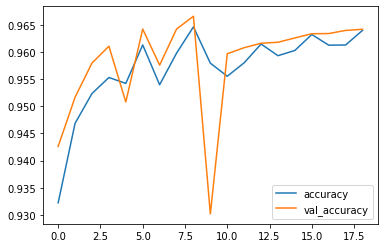

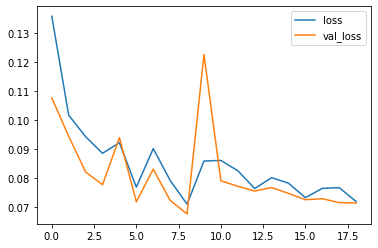

In [ ]:
trainer(model=jewel6, X_train=X_train_4_pad, y_train=y_train_4, X_val=X_val_4_pad, y_val=y_val_4, epochs=30, patience=10, filename_suffix='')

shapes shape: (4, 20, 20)
shapes shape: (4, 24, 24, 1)
shapes_pred shape: (4, 20, 20, 1)


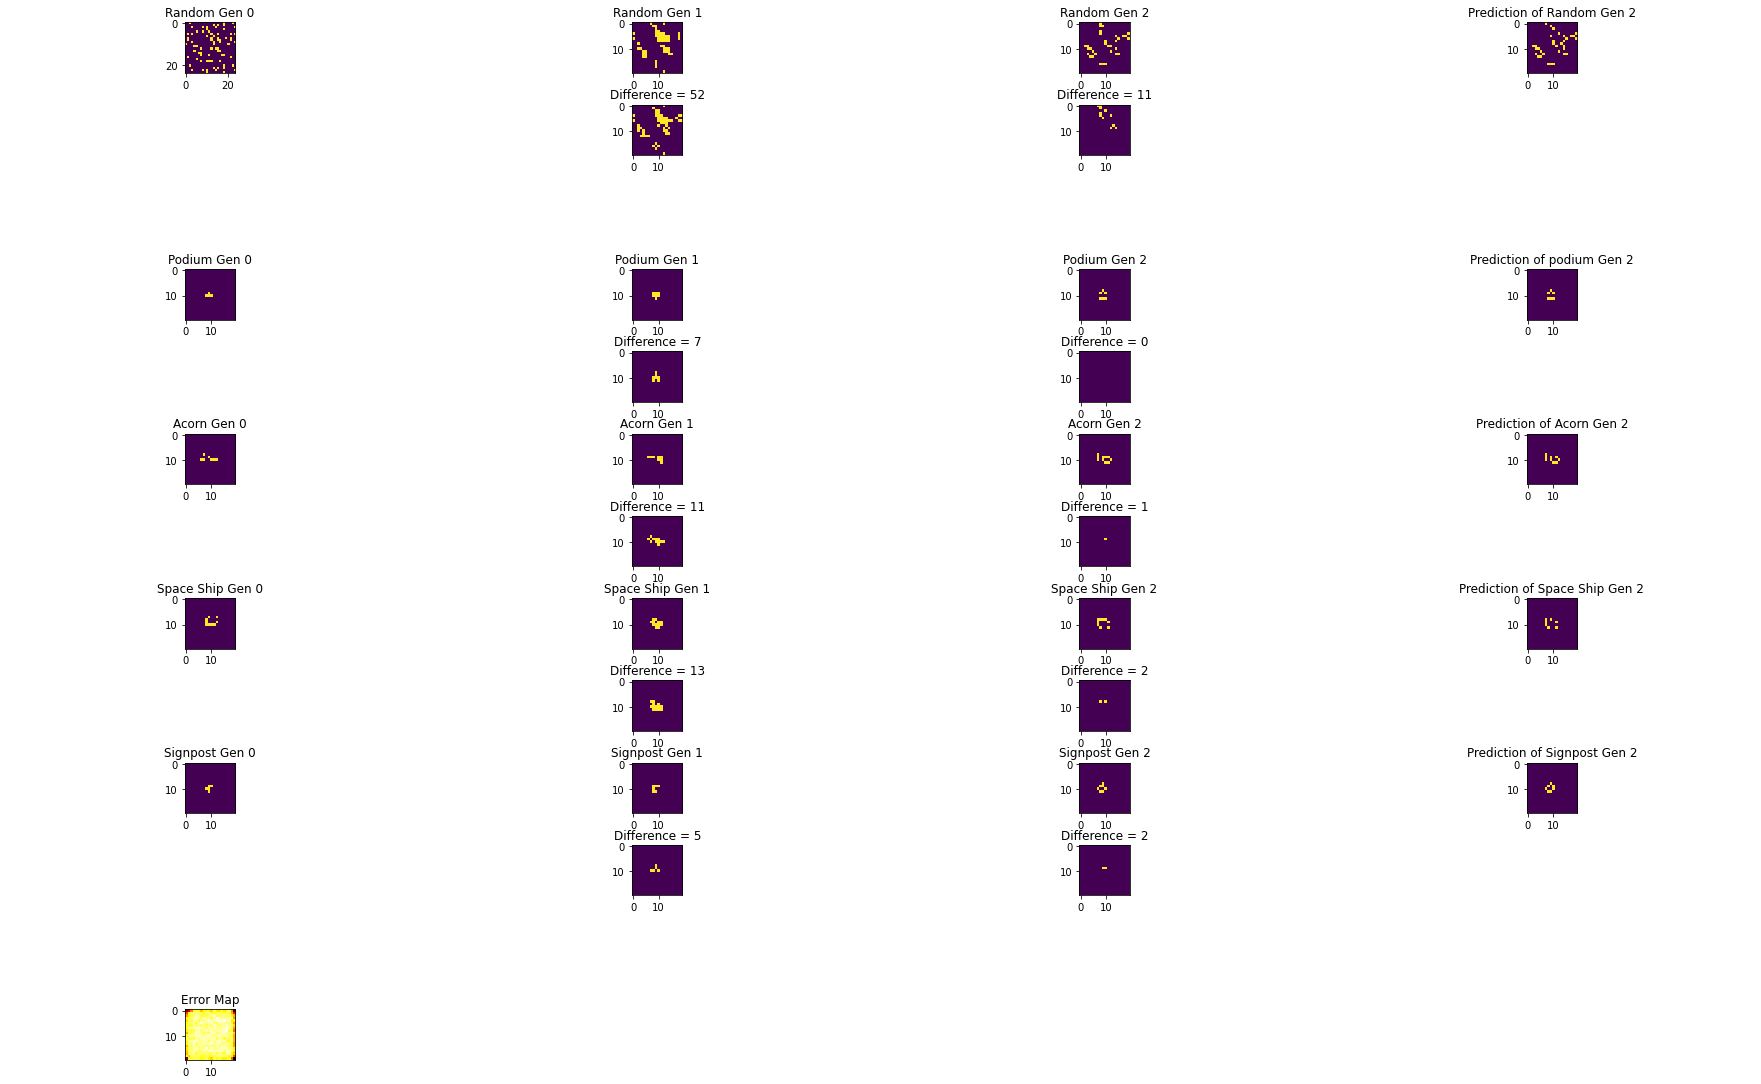

Percentage Difference: 6.25%

Overall Model Accuracy 96.8603375 %
       frame_n  percent_diff  weighted_diff
1513      1513     32.758621           3360
10511    10511     16.071429           3168
15850    15850     32.075472           3075
15076    15076     30.357143           2960
10845    10845     21.818182           2881
Average percentage difference = 36.348079145833324
Frame 122.22222222222223 had the best prediction (lowest percentage difference)


In [ ]:
tester(model=jewel6, X=X_test_4_pad, X_unp=X_test_4, y=y_test_4, steps=2, frame_n=10887)

In [ ]:
X_test_pad_5.shape

(20000, 24, 24, 1)